In [2]:
import numpy as np
from sklearn.neural_network import BernoulliRBM
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import sem
import seaborn as sns
import pickle
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone


sns.set_theme(style='white',font_scale=1.5)

In [3]:
def shuffle_spikes(X, min_shift=100):
    X_shuff = np.zeros(X.shape)
    for i in range(X.shape[-1]):
        X_shuff[:,i] = np.roll(X[:,i], np.random.choice(
            np.arange(min_shift, X.shape[0])))
    return X_shuff

def binarize(traces):
    stds = np.std(traces,axis=-1)
    means = np.mean(traces,axis=-1)
    out = np.zeros_like(traces)
    for i in range(traces.shape[0]):
        for j in range(traces.shape[1]):
            if traces[i,j]-means[i]>stds[i]:
                out[i][j] = 1
            else:
                out[i][j] = 0

    return out

# Stimulus specific component
Decoding the six stimuli all together, without non stimulus periods

<Figure size 1440x360 with 0 Axes>

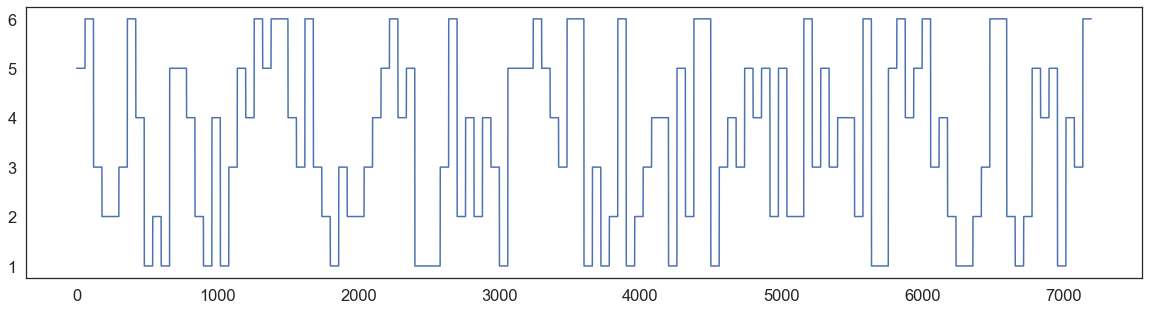

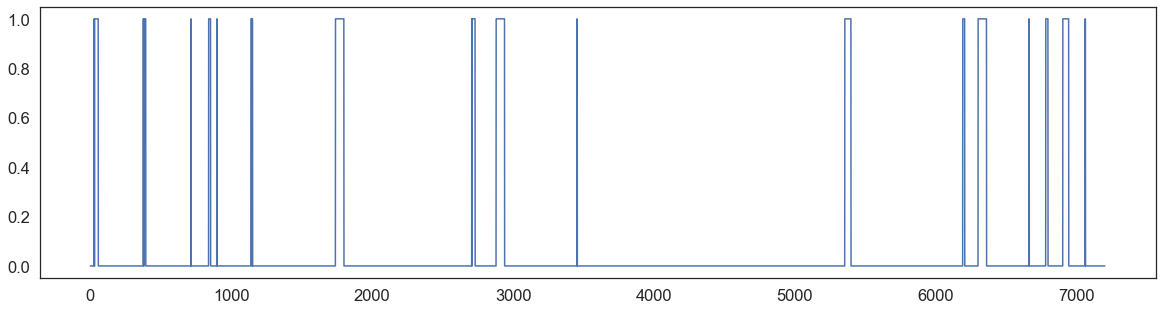

In [5]:
stimulus_only = True # use only stimulus periods
binarize_traces = True

data = np.load('../../../../data/raw_data/nike_calcium_trace.npy')
if binarize_traces:
    data = binarize(data)

X_all = data.T
with open('../../../../data/raw_data/behaviour.pickle','rb') as f:
    behaviour = pickle.load(f)

stimulus_duration = 60 # in indexes
stimuli = [1,2,3,4,5,6]

plt.figure(figsize=(20,5))
y_all = np.zeros(X_all.shape[0])
for s in stimuli:
    stim_mask = np.zeros(X_all.shape[0])
    for onset in behaviour[f'sound{s}']:
        stim_mask[onset:onset+stimulus_duration] = 1
        y_all[onset:onset+stimulus_duration] = s
    
# isolate stimuli periods   
if stimulus_only: 
    X = X_all[y_all>0]
    y = y_all[y_all>0]
else:
    X = X_all
    y = y_all

plt.figure(figsize=(20,5))
plt.plot(y)
plt.figure(figsize=(20,5))
plt.plot(X[:,0])



In [74]:
n_splits = 10
n_shuff = 10

logistic = linear_model.LogisticRegression(solver="newton-cg", tol=1,C=1000)
scaler = StandardScaler()
classifier = Pipeline(steps=[("scaler",scaler), ("logistic", logistic)])


kf = StratifiedKFold(n_splits=n_splits,shuffle=True)
performance = []
shuffled_y_performance = []
shuffled_x_performance = []
models = []

for i,(train_index, test_index) in enumerate(kf.split(X,y)):
    print(f'fold {i+1}/{n_splits}')
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # LR classifier
    split_classifier = clone(classifier)
    split_classifier.fit(X_train, y_train)

    y_pred = split_classifier.predict(X_test)
    performance.append(f1_score(y_test,y_pred,average='weighted')) 
    models.append(split_classifier)

    for _ in tqdm(range(n_shuff)):
        X_shuff = shuffle_spikes(X)
        #X_test_shuff = X_test

        X_train_shuff, X_test_shuff = X_shuff[train_index], X_shuff[test_index]


        # LR classifier
        split_classifier = clone(classifier)
        split_classifier.fit(X_train_shuff, y_train)

        y_pred_shuff = split_classifier.predict(X_test_shuff)
        shuffled_x_performance.append(f1_score(y_test,y_pred_shuff,average='weighted')) 
 
        shuffled_y_performance.append(f1_score(y_test,np.random.permutation(y_test),average='weighted'))

best_model = models[np.argmax(performance)]



fold 1/10


100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


fold 2/10


100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


fold 3/10


100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


fold 4/10


100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


fold 5/10


100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


fold 6/10


100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


fold 7/10


100%|██████████| 10/10 [00:03<00:00,  2.89it/s]


fold 8/10


100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


fold 9/10


100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


fold 10/10


100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


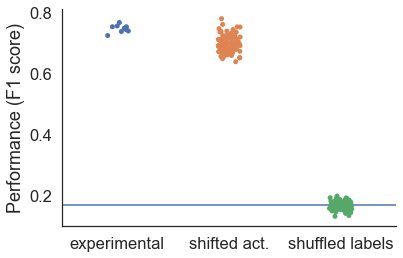

In [77]:
sns.stripplot(data=[performance,shuffled_x_performance,shuffled_y_performance])
plt.axhline(y=1.0/6.0,label='expected chance level')
plt.xticks([0,1,2],labels=['experimental','shifted act.','shuffled labels'])
plt.ylabel('Performance (F1 score)')
sns.despine()


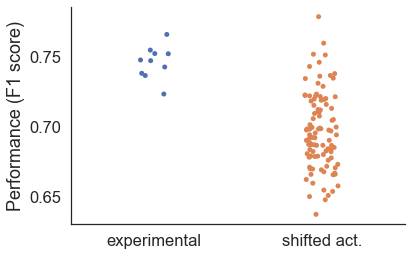

In [78]:
sns.stripplot(data=[performance,shuffled_x_performance])
#sns.pointplot(data=[performance,shuffled_x_performance])
#plt.axhline(y=1.0/6.0,label='expected chance level')
plt.xticks([0,1],labels=['experimental','shifted act.'])
plt.ylabel('Performance (F1 score)')
sns.despine()

In [79]:
lr = best_model['logistic']
weights = lr.coef_

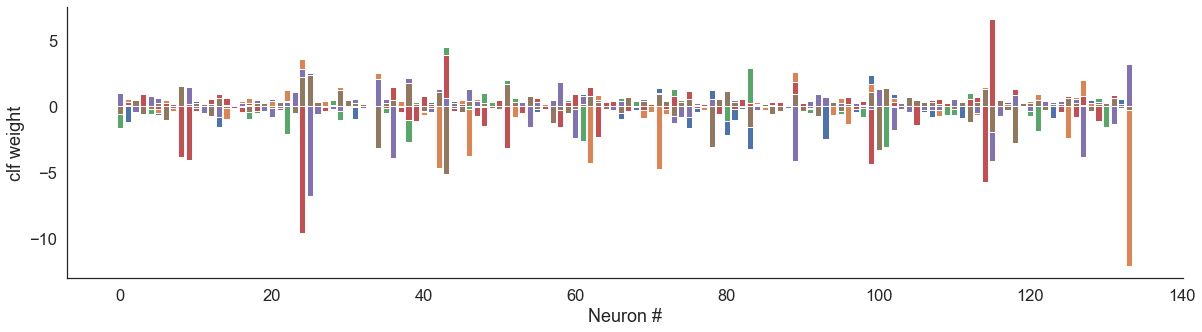

In [80]:
plt.figure(figsize=(20,5))
for i,w in enumerate(weights):
    plt.bar(np.arange(len(w)),w,label=f'stim {i+1}')

plt.xlabel("Neuron #")
plt.ylabel("clf weight")

sns.despine()

## stimulus dependent activity

In [81]:
scaler = StandardScaler()
scaled_X  = scaler.fit_transform(X)
ensemble_activity = scaled_X @weights.T

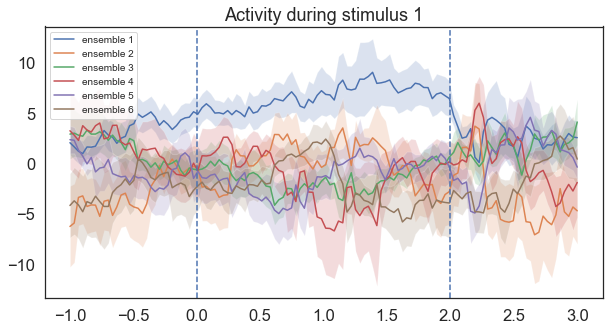

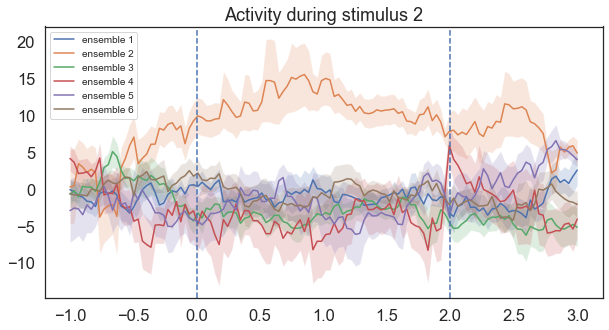

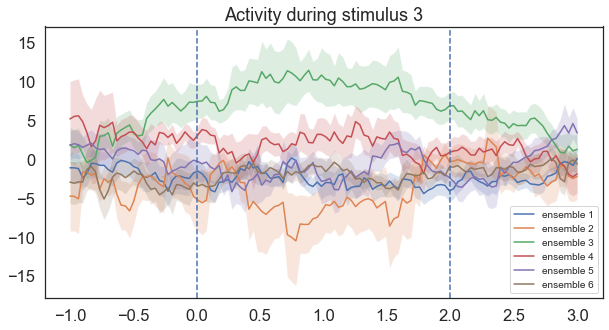

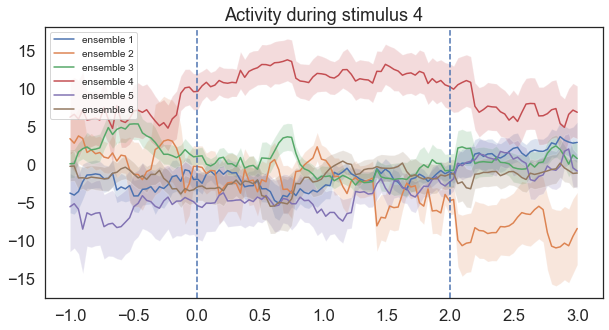

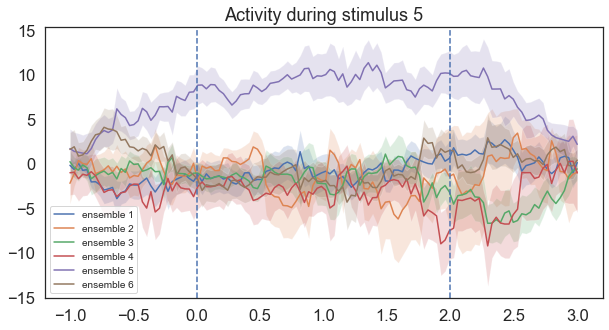

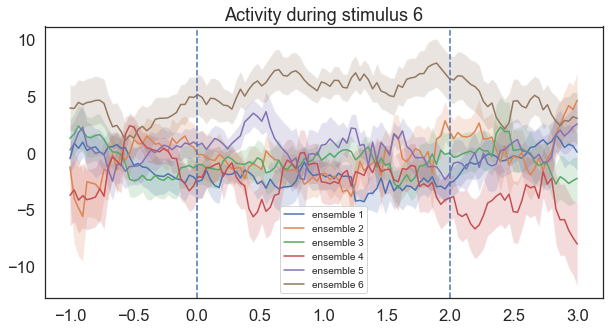

In [82]:
from scipy.stats import sem

scaler = StandardScaler()
X_scaled  = scaler.fit_transform(X_all)

for stimulus in stimuli:

    ensamble_mat = []
    for onset in behaviour[f'sound{stimulus}']:
            X_stim = X_scaled[onset-30:onset+stimulus_duration+30]
            ensemble_activity = X_stim @ weights.T
            ensamble_mat.append(ensemble_activity)
    ensamble_mat = np.asarray(ensamble_mat)

    avg_activity = np.mean(ensamble_mat,axis=0)
    std_activity = sem(ensamble_mat,axis=0)
    plt.figure(figsize=(10,5))
    plt.title(f'Activity during stimulus {stimulus}')
    for i in range(avg_activity.shape[-1]):
        time = np.linspace(-1,3,avg_activity.shape[0])
        plt.plot(time,avg_activity[:,i],label=f'ensemble {i+1}')
        plt.fill_between(time,avg_activity[:,i]-std_activity[:,i],avg_activity[:,i]+std_activity[:,i],alpha=0.2)
        plt.legend(fontsize=10)

    plt.axvline(x=0,linestyle='--')
    plt.axvline(x=2,linestyle='--')

# classification in time

In [6]:
n_splits = 10
n_shuff = 10

n_periods = 4
len_period = X.shape[0]//4

logistic = linear_model.LogisticRegression(solver="newton-cg", tol=1,C=1000)
scaler = StandardScaler()
classifier = Pipeline(steps=[("scaler",scaler), ("logistic", logistic)])


kf = StratifiedKFold(n_splits=n_splits,shuffle=True)
t_performance = []
t_models = []



for t in range(n_periods):
    Xt = X[t*len_period:(t+1)*len_period]
    yt = y[t*len_period:(t+1)*len_period]

    performance = []
    models = []


    for i,(train_index, test_index) in enumerate(kf.split(Xt,yt)):
        #print(f'fold {i+1}/{n_splits}')
        X_train, X_test = Xt[train_index], Xt[test_index]
        y_train, y_test = yt[train_index], yt[test_index]

        # LR classifier
        split_classifier = clone(classifier)
        split_classifier.fit(X_train, y_train)

        y_pred = split_classifier.predict(X_test)
        performance.append(f1_score(y_test,y_pred,average='weighted')) 
        models.append(split_classifier)

    best_model = models[np.argmax(performance)]

    t_performance.append(performance)
    t_models.append(best_model)

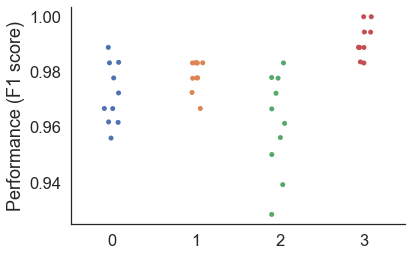

In [7]:
sns.stripplot(data=t_performance)
#plt.axhline(y=1.0/6.0,label='expected chance level')
#plt.xticks([0,1,2],labels=['experimental','shifted act.','shuffled labels'])
plt.ylabel('Performance (F1 score)')
sns.despine()

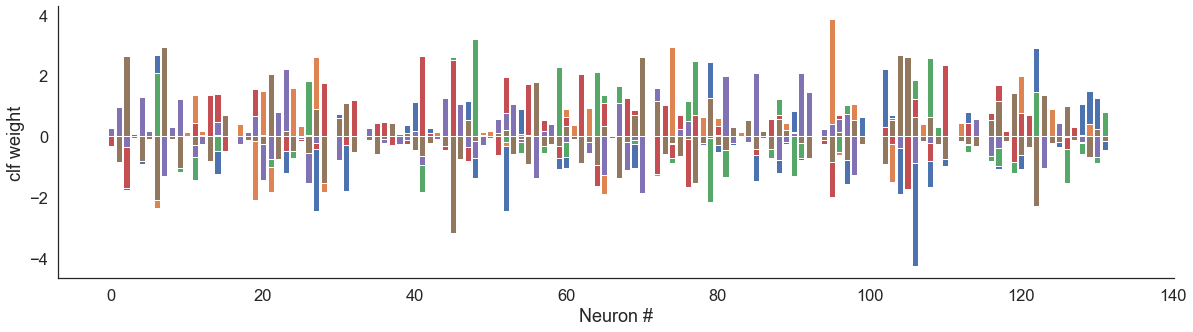

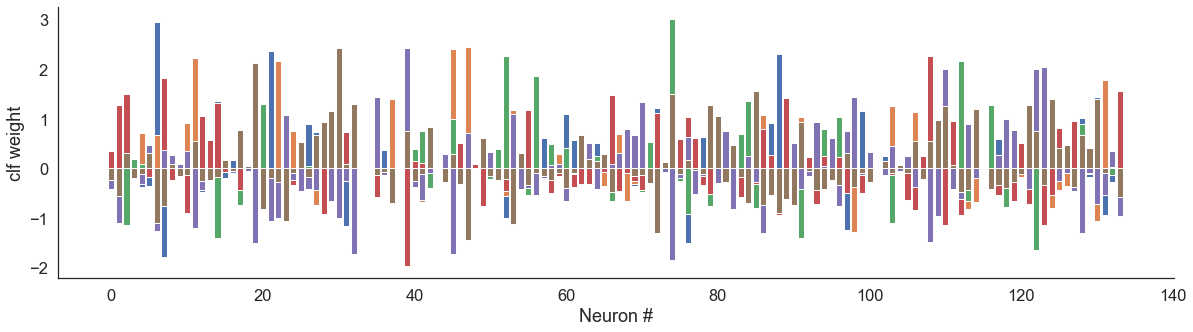

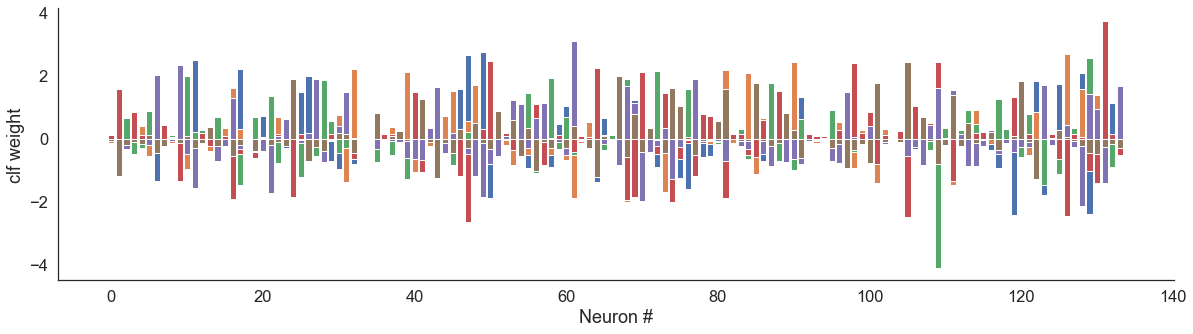

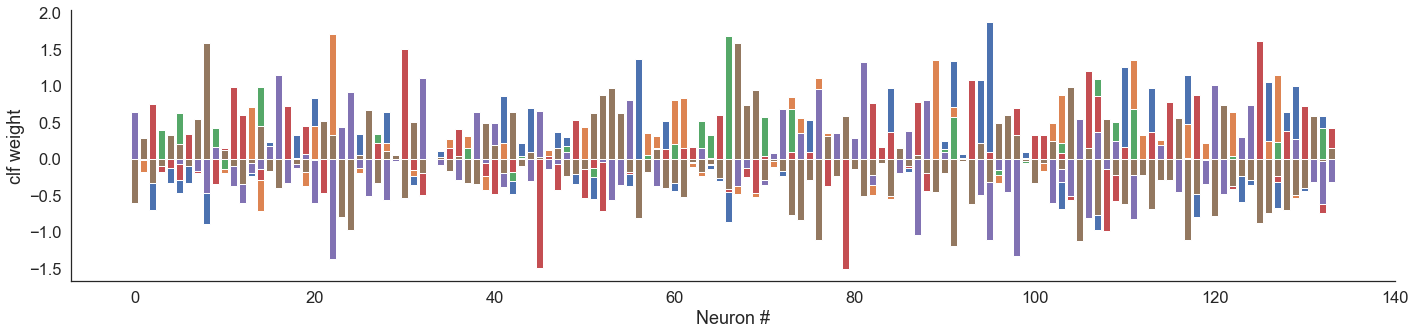

In [8]:
for model in t_models:
    weights = model['logistic'].coef_
    plt.figure(figsize=(20,5))
    for i,w in enumerate(weights):
        plt.bar(np.arange(len(w)),w,label=f'stim {i+1}')

    plt.xlabel("Neuron #")
    plt.ylabel("clf weight")

    sns.despine()

plt.tight_layout()

In [15]:
# correlation between ensembles
corrs = []

weights_0 = t_models[0]['logistic'].coef_
for s in range(len(weights_0)):
    s_corr = []
    for t in range(len(t_models)):
        weights = t_models[t]['logistic'].coef_[s]
        corr = np.corrcoef(weights_0[s],weights)[0,1]
        s_corr.append(corr)
    corrs.append(s_corr)

In [16]:
weights_0.shape

(6, 134)

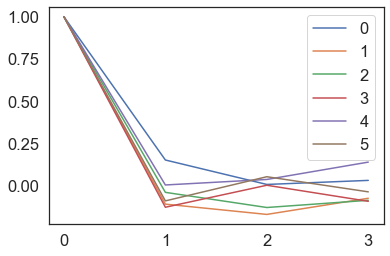

In [17]:
for i,c in enumerate(corrs):
    plt.plot(c,label=i)

plt.legend()